In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var
import sys
from functools import partial
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
from candlesticks import candlesticks
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 30
periods = 100
#multi_periods = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 40, 80, 160,]
multi_periods = [5, 10, 20, 40, 80, 160]
bankroll = 15000
vol_lookback = 100
smooth = int(np.ceil(periods/4))
atr_periods = 80

In [3]:
contract = pd.read_pickle('data/minute_NQ_cont_non_active_included.pickle')
contract = contract.loc['20190101': '20191231']
#contract = contract.loc['20190401':]
#contract = contract.loc['20180202': '20180630']
#contract = contract.loc['20190101': '20190410']

In [4]:
vols = pd.DataFrame({'close': contract.close,})
vols['returns'] = vols['close'].pct_change()
vols['vol_returns'] = vols['returns'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()
vols['vol_price'] = vols['vol_returns'] * vols['close']

In [5]:
#avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol = contract.volume.rolling(time_int).sum().mean()
avg_vol

9915.49165665634

In [6]:
vol_candles = group_by_volume(contract, avg_vol)
vol_candles['atr'] = get_ATR(vol_candles, atr_periods)

In [7]:
data = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                     'close': vol_candles.close})
data.set_index('date', inplace=True)

In [8]:
t = len(multi_periods)/2
t

3.0

In [9]:
for p in multi_periods:
    data[f'max_{p}'] = (data.close >= data.close.rolling(p).max()) * 1
    data[f'min_{p}'] = (data.close <= data.close.rolling(p).min()) * 1
data['max_index'] = round(((sum([data[f'max_{p}'] for p in multi_periods])) - t + 1).clip(lower=0),0)
data['min_index'] = round(((sum([data[f'min_{p}'] for p in multi_periods])) - t + 1).clip(lower=0),0)
data['index'] = (data['max_index'] - data['min_index']).ewm(span=10).mean()
#.rolling(100).mean()
#data['index_diff'] = data['index'].diff(30)
#data['index_diff_roll'] = data['index_diff'].rolling(5).sum()
data.tail()

,open,close,max_5,min_5,max_10,min_10,max_20,min_20,max_40,min_40,max_80,min_80,max_160,min_160,max_index,min_index,index
date,,,,,,,,,,,,,,,,,
2019-09-04 17:11:00,7681.00,7685.50,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.059505
2019-09-04 17:28:00,7685.75,7688.50,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.048686
2019-09-04 17:42:00,7688.75,7701.25,1,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.039834
2019-09-04 18:08:00,7701.75,7702.00,1,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.032592
2019-09-04 18:31:00,7702.00,7697.25,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.026666


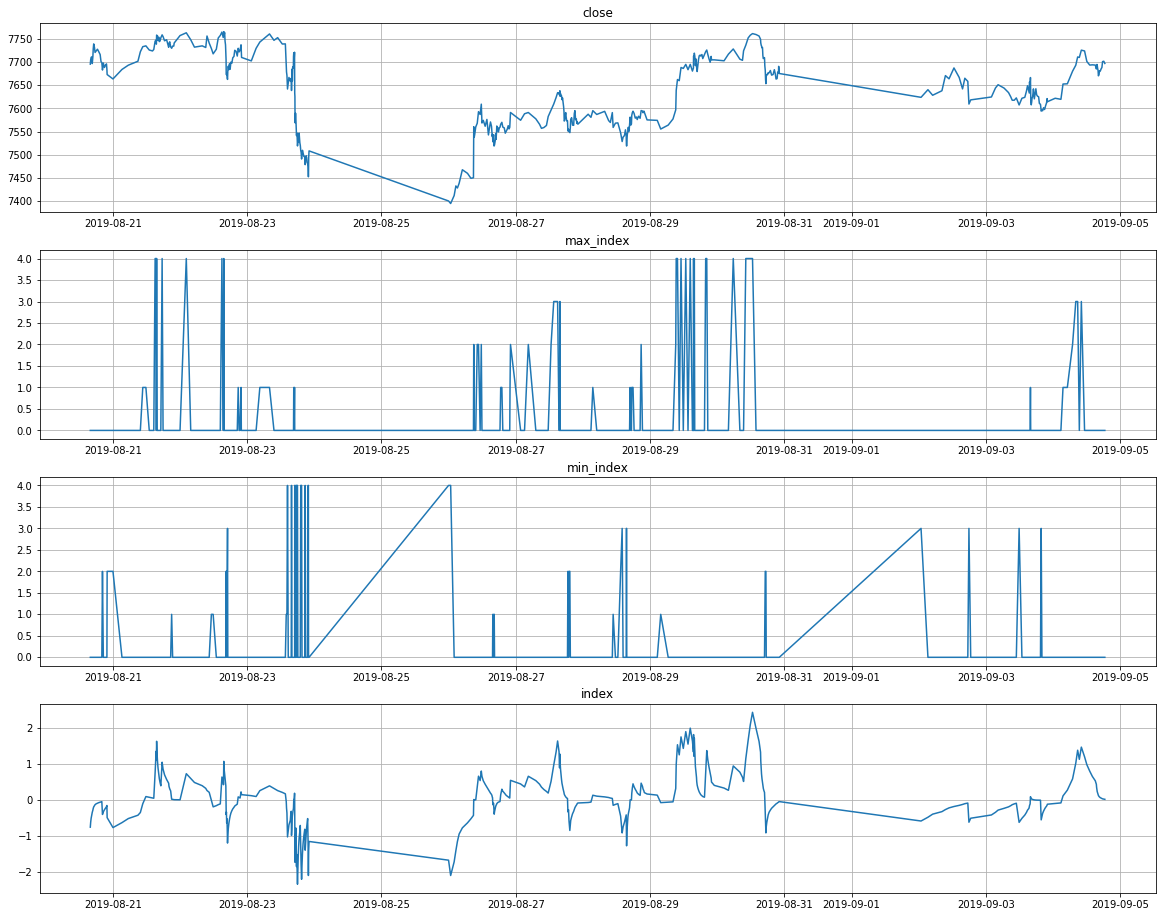

In [10]:
x = data.iloc[-500:]
plot(x[['close', 'max_index', 'min_index','index']])

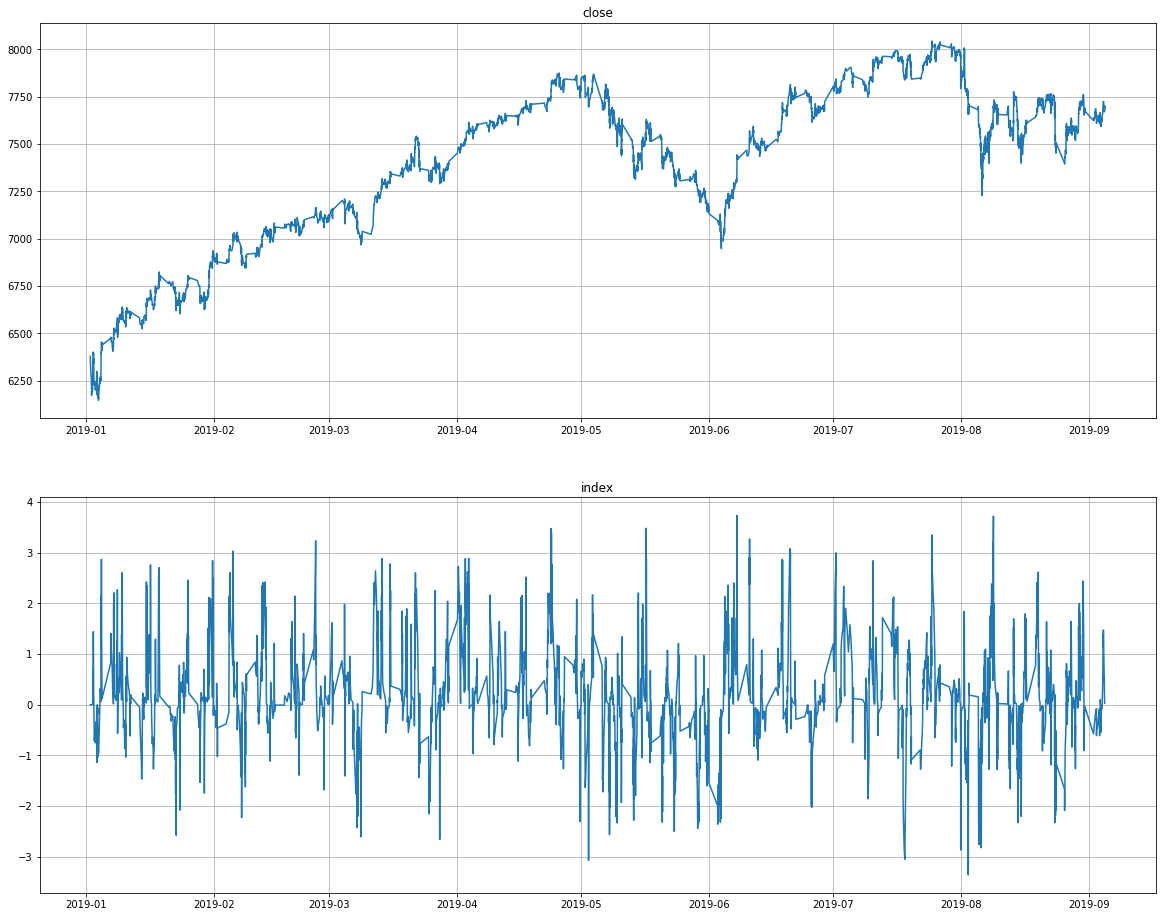

In [11]:
plot(data[['close', 'index']]);

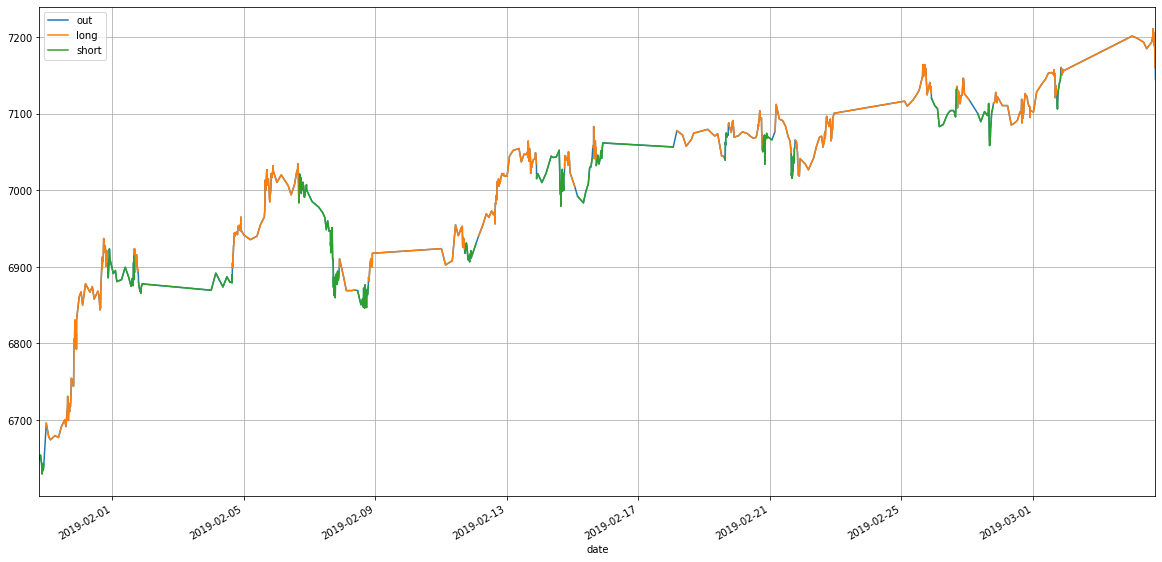

In [12]:
chart_price(data['close'].iloc[900:1800], data['index'].iloc[900:1800], 0);

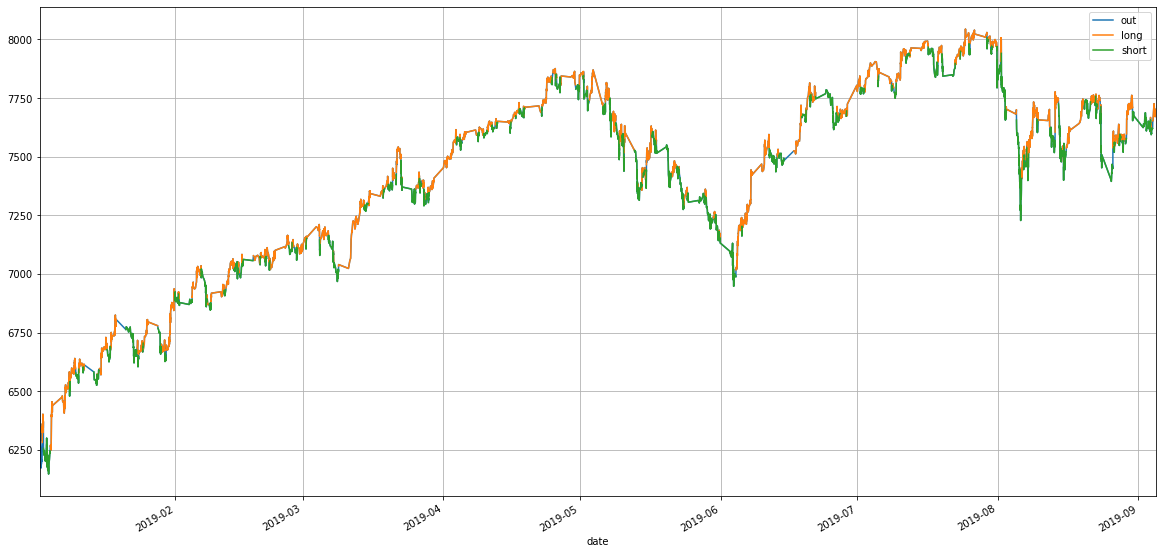

In [13]:
chart_price(data['close'], data['index'], 0);

In [14]:
stats = pd.DataFrame()
dailys = pd.DataFrame()
returns = pd.DataFrame()
for i in [0, .5, .7, 1,2,3]:
    b = v_backtester(data['close'], data['index'], i)
    r = perf_var(b, False)
    stats[i] = r.stats
    dailys[i] = r.daily.balance
    returns[i] = r.daily['returns']

In [15]:
stats

,0.0,0.5,0.7,1.0,2.0,3.0
Annual return,-0.0825906,0.045613,0.106346,0.100485,-0.0669423,0.00167441
Cumulative returns,-0.0587498,0.0318244,0.0735646,0.0695669,-0.0475015,0.00117578
Annual volatility,0.205039,0.125894,0.102733,0.0807179,0.0357627,0.00782974
Sharpe ratio,-0.317268,0.416803,1.03488,1.22642,-1.9194,0.217563
Calmar ratio,-0.484193,0.976355,2.23887,3.6314,-1.37028,0.303887
Stability,0.0160643,0.691522,0.873266,0.809315,0.583254,0.162928
Max drawdown,-0.170574,-0.0467176,-0.0474998,-0.0276712,-0.048853,-0.00550996
Omega ratio,0.944757,1.07979,1.22544,1.28259,0.596104,1.13106
Sortino ratio,-0.409456,0.647374,1.72417,2.24353,-2.53637,0.380235
Skew,-1.18212,0.337987,0.572349,1.24204,0.433988,3.23508
